In [48]:
import sys
sys.path.append('..')

import os
from pprint import pprint
import numpy as np
import random
from dicomhd import io as dhd_io
from medpy.io import load as load_lbl
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline


In [49]:
out_path = '../data/tfrecods/'
out_train_fname = 'train-st-3'
out_val_fname = 'val-st-3'
out_train_ffname = os.path.join(out_path, out_train_fname + '.tfrecords')
out_val_ffname = os.path.join(out_path, out_val_fname + '.tfrecords')

# patch size: [n_rows, n_cols, n_planes]
n_rows = 32
n_cols = 32
n_planes = 8
st = 2 # stride

n_classes = 6
n_channel = 1
epoch = 100
batch_size = 128

In [67]:
def _parse_image_function(example_proto):
    image_feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'lbl': tf.io.FixedLenFeature([], tf.int64),
        'img': tf.io.FixedLenFeature([], tf.string),
    }

    features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.io.parse_tensor(features['img'], out_type=tf.float32)
    image = tf.io.decode_raw(features['img'], tf.float32)
    image.set_shape([n_planes * n_rows * n_cols])
    image = tf.reshape(image, [n_planes, n_rows, n_cols])

    label = tf.cast(features['lbl'], tf.int64)
    label = tf.one_hot(label, n_classes)
    
    print(image.shape, label.shape)

    return image, label

def count_tfrecord_examples(tfrecord_path):
    """
    Counts the total number of examples in a collection of TFRecord files.

    :param tfrecords_dir: directory that is assumed to contain only TFRecord files
    :return: the total number of examples in the collection of TFRecord files
        found in the specified directory
    """
    count = 0
    count += sum(1 for _ in tf.data.TFRecordDataset(tfrecord_path))

    return count

def _parse_image(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
    image_feature_description = {
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),
            'lbl': tf.io.FixedLenFeature([], tf.int64),
            'img': tf.io.FixedLenFeature([], tf.string),
        }
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _decode_image(example):
    example['img'] = tf.io.parse_tensor(example['img'], out_type=tf.float32)
    example['lbl'] = tf.cast(example['lbl'], tf.int64)
#     example['lbl'] = tf.one_hot(example['lbl'], 6)
    
    return example['img'], example['lbl']

def _data_normalize(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.per_image_standardization(image) #normalization
    return image, label

def _data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.per_image_standardization(image) #normalization
    image = tf.image.random_flip_left_right(image) #flip
    image = tf.image.rot90(image) # rotation
    
    return image, label 

def load_dataset(out_ffname, train):

    print(out_ffname)
    dataset = tf.data.TFRecordDataset(out_ffname)

    dataset = dataset.map(_parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(_decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

def class_weight(train_dataset):
#      n_samples / (n_classes * np.bincount(y))
    labels, counts = np.unique(np.fromiter(train_dataset.map(lambda x, y: y), np.int32), return_counts=True)
    w = sum(counts) / (n_classes * counts)
    return w

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

../data/tfrecods/train-st-3.tfrecords
nm of training samples: 1698
../data/tfrecods/val-st-3.tfrecords
nm of validation samples: 161


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'normal'),
  Text(1, 0, 'hyperlucnet'),
  Text(2, 0, 'groundglass'),
  Text(3, 0, 'reticular'),
  Text(4, 0, 'honeycomb'),
  Text(5, 0, 'consolidation')])

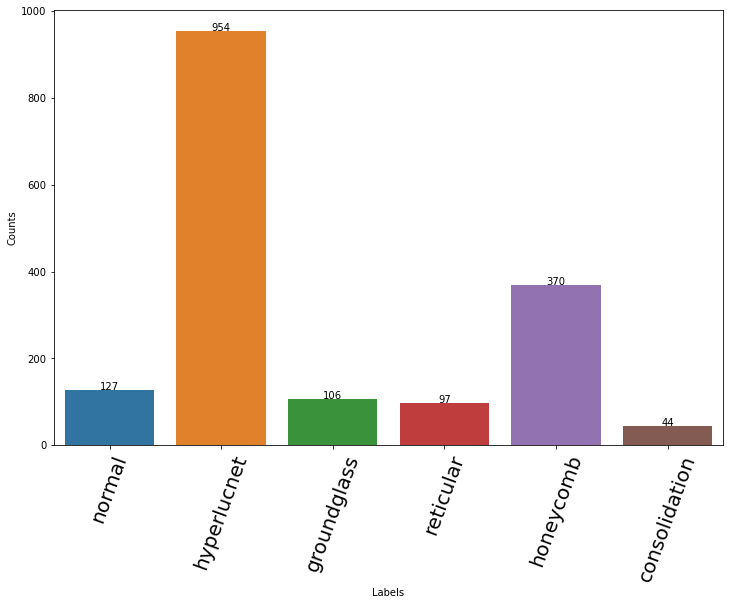

In [51]:
# load data
out_path = '../data/tfrecods/'
out_train_fname = 'train-st-3'
out_val_fname = 'val-st-3'
out_train_ffname = os.path.join(out_path, out_train_fname + '.tfrecords')
out_val_ffname = os.path.join(out_path, out_val_fname + '.tfrecords')
train_dataset = load_dataset(out_train_ffname, train = True)
print(f'nm of training samples: {count_tfrecord_examples(out_train_ffname)}')
# load val data
val_dataset = load_dataset(out_val_ffname, train = False)
print(f'nm of validation samples: {count_tfrecord_examples(out_val_ffname)}')


label, counts = np.unique(np.fromiter(train_dataset.map(lambda x, y: y), np.int32), return_counts=True)
plt.figure(figsize=(12,8))
plt.ylabel('Counts')
plt.xlabel('Labels')
labels = ['normal', 'hyperlucnet','groundglass','reticular','honeycomb','consolidation']
classes = {1: 'normal', 
          2: 'hyperlucnet',
          3: 'groundglass',
          4: 'reticular',
          5: 'honeycomb',
          6: 'consolidation'}
bars = sns.barplot(x = labels, y = counts) 
show_values_on_bars(bars)  
plt.xticks(rotation=70, fontsize=20)


In [69]:
weight = class_weight(train_dataset)
weight = {i+1: weight[i] for i in range(6)}

weight


{1: 2.2283464566929134,
 2: 0.2966457023060797,
 3: 2.669811320754717,
 4: 2.917525773195876,
 5: 0.7648648648648648,
 6: 6.431818181818182}

../data/tfrecods/train-st-3.tfrecords
nm of training samples: 1698
../data/tfrecods/val-st-3.tfrecords
nm of validation samples: 161


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'normal'),
  Text(1, 0, 'hyperlucnet'),
  Text(2, 0, 'groundglass'),
  Text(3, 0, 'reticular'),
  Text(4, 0, 'honeycomb'),
  Text(5, 0, 'consolidation')])

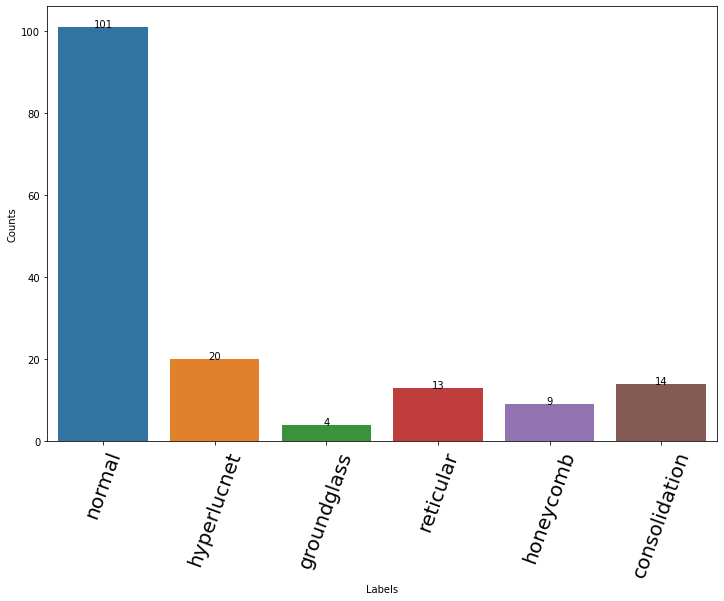

In [15]:
out_path = '../data/tfrecods/'
out_train_fname = 'train-st-3'
out_val_fname = 'val-st-3'
out_train_ffname = os.path.join(out_path, out_train_fname + '.tfrecords')
out_val_ffname = os.path.join(out_path, out_val_fname + '.tfrecords')

train_dataset = load_dataset(epoch, batch_size, out_train_ffname, train = True)
print(f'nm of training samples: {count_tfrecord_examples(out_train_ffname)}')
# load val data
val_dataset = load_dataset(epoch, batch_size, out_val_ffname, train = False)
print(f'nm of validation samples: {count_tfrecord_examples(out_val_ffname)}')


labels, counts = np.unique(np.fromiter(val_dataset.map(lambda x, y: y), np.int32), return_counts=True)
plt.figure(figsize=(12,8))
plt.ylabel('Counts')
plt.xlabel('Labels')
labels = ['normal', 'hyperlucnet','groundglass','reticular','honeycomb','consolidation']
classes = {1: 'normal', 
          2: 'hyperlucnet',
          3: 'groundglass',
          4: 'reticular',
          5: 'honeycomb',
          6: 'consolidation'}
bars = sns.barplot(x = labels, y = counts) 
show_values_on_bars(bars)  
plt.xticks(rotation=70, fontsize=20)

In [73]:
for i, example in enumerate(train_dataset):
    image_raw = example[1].numpy()
    print(i, example[1].shape, example[1].shape)
    break
print(image_raw.min(),image_raw.max())

0 () ()
5 5


5


IndexError: index 15 is out of bounds for axis 0 with size 15

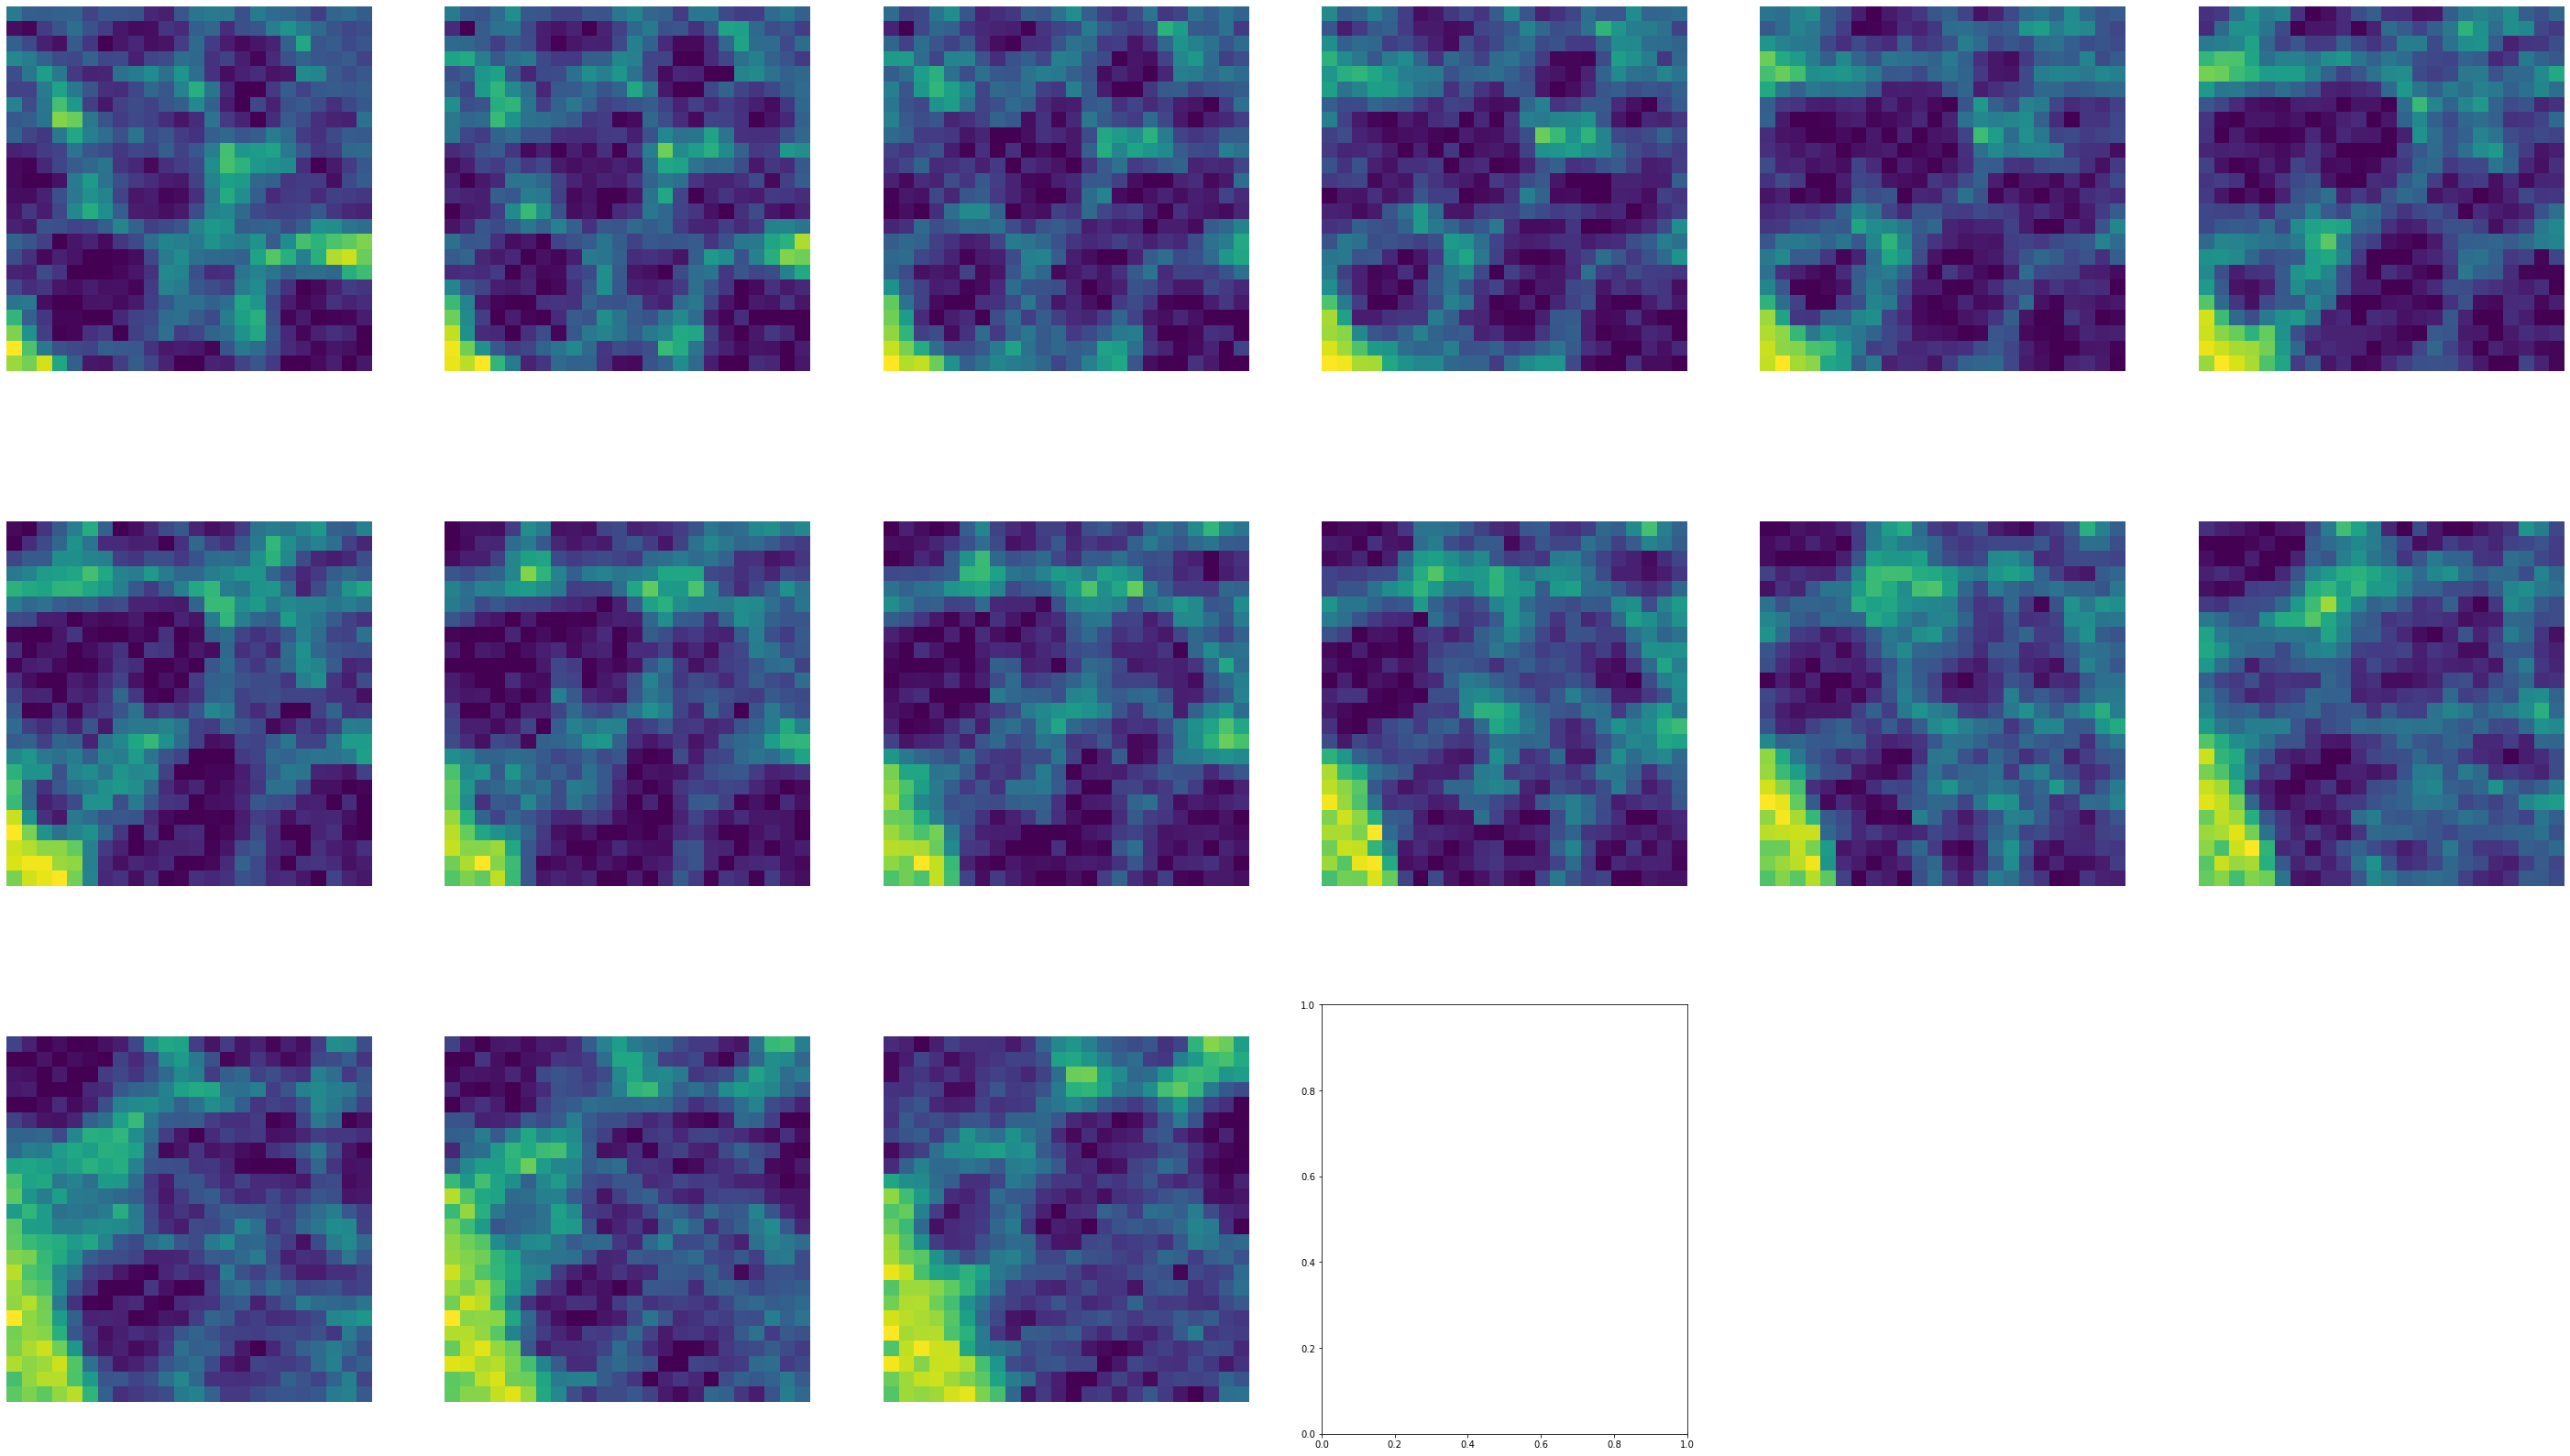

In [74]:
def show_batch(image_batch):
    plt.figure(figsize=(50, 50))
    for n in range(30):
        ax = plt.subplot(5, 6, n+1 )
        plt.imshow(image_batch[n])
        plt.axis("off")

image_batch, label_batch = next(iter(train_dataset))
image_batch.shape
print(label_batch.numpy())
# image_batch[...,0].numpy().shape
show_batch(image_batch[...,0].numpy())

In [70]:
classes = {1: 'normal', 
          2: 'hyperlucnet',
          3: 'groundglass',
          4: 'reticular',
          5: 'honeycomb',
          6: 'consolidation'}